# Basic setup

Optimize the size of a reservoir (progress 1) under some uncertainty (progress 2).

Suppose we have the following inputs:
 - $q_t$: precipitation or inflow
 - $d_t$: water demand
 
Choice variables:
 - $w_t$: withdrawals
 - $x_t$: supersource water
 - $k_t$: investment in increaseing capacity
 
State space variables:
 - $v_t$: reservoir level
 - $c_t$: reservoir capacity
 
Following reservoir dynamics:
$$v_{t+1} = v_t + q_t - w_t$$
$$c_{t+1} = c_t + k_t$$
$v_0 = c_0 = 0$

Constrained such that,
 - $w_t + x_t \ge d_t$: Must satisfy demand
 - $v_t \le V_t$: Cannot over-fill reservoir
 - $w_t \le v_{t-1} + q_t$: Cannot over-withdrawal reservoir
 
And the objective is to minimize costs:
$$\sum_t (A x_t + k_t) e^{-\delta t}$$

## Handling of uncertainty

We have N Monte Carlo-like scenarios of the inputs, $q_{it}$ and $d_{it}$.  In the example below, only
precipitation will vary by scenario.  Each scenario has a probability, $p_i$, s.t. $\sum p_i = 1$.

We estimate separate timeseries of the immediate choice variables, $w_{it}$ and $x_{it}$.  These do not require long-term planning, and so do not necessitate a larger state-space.  However, there is just one timeseries for investment choices, $k_t$.

The objective function now takes the expected value of these costs:
$$\sum_t \left(A \left(\sum_i p_i x_{it}\right) + k_t\right) e^{-\delta t}$$

## Handling of optimization under uncertainty

I propose that AWASH not do proper optimization under uncertainty.  Under proper optimization, the state-space transition in each period is uncertain, which both means that optimization is taken under the knowledge that more information is provided in each period, and that the state-space needs to be enumerated.

Instead, I propose that an entire timeseries of long-term investments will be made in period $t_0$, not knowing which scenario will be entered.  This investment will then be taken, the uncertainty resolved, and a new timeseries of investments will be optimized for in period $t_1$.  This continues iteratively.  Furthermore, it should be iteratively estimated for each of the N scenarios.

Under this plan, the number of variables only needs to multiply by the number of scenarios, and only for those variables that do not reflect long-term investments.  The main loss is that the rational optimizer will design strategies that wait for uncertainty to be resolved, since it will never be resolved (in the future periods considered by the optimization, the optimizer still will not "know" which scenario it is in, as far as investment decisions are concerned).  However, this is preferable to having scenario-specific investment decision variables, where the optimizer will always wait one more period to know which scenario it is in.

# Single Optimization Example

In [1]:
using JuMP
using Clp
using Gadfly
using DataFrames

In [2]:
time = 0:49
precip1 = repeat([1], inner=length(time))
precip2 = (cos.(2*pi*time / 25) + 1) / 3 + 1/3
demand = repeat([.5], inner=length(time));

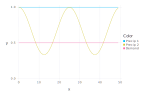

In [3]:
plot(x=repmat(time, 3), y=[precip1; precip2; demand], color=repeat(["Precip 1", "Precip 2", "Demand"], inner=50), Geom.line)

In [4]:
m = Model(solver=ClpSolver())

@variable(m, kk[time] >= 0) # Investment
@variable(m, xx1[time] >= 0) # Supersource under scenario 1
@variable(m, ww1[time] >= 0) # Withdrawals under scenario 1
@variable(m, xx2[time] >= 0) # Supersource under scenario 2
@variable(m, ww2[time] >= 0) # Withdrawals under scenario 2

ww2[i] ≥ 0 ∀ i ∈ {0,1,…,48,49}

In [5]:
# Always satisfy demand
@constraint(m, ww1[time] + xx1[time] .>= demand[time + 1])
@constraint(m, ww2[time] + xx2[time] .>= demand[time + 1])

50-element Array{JuMP.ConstraintRef{JuMP.Model,JuMP.GenericRangeConstraint{JuMP.GenericAffExpr{Float64,JuMP.Variable}}},1}:
 ww2[0] + xx2[0] ≥ 0.5  
 ww2[1] + xx2[1] ≥ 0.5  
 ww2[2] + xx2[2] ≥ 0.5  
 ww2[3] + xx2[3] ≥ 0.5  
 ww2[4] + xx2[4] ≥ 0.5  
 ww2[5] + xx2[5] ≥ 0.5  
 ww2[6] + xx2[6] ≥ 0.5  
 ww2[7] + xx2[7] ≥ 0.5  
 ww2[8] + xx2[8] ≥ 0.5  
 ww2[9] + xx2[9] ≥ 0.5  
 ww2[10] + xx2[10] ≥ 0.5
 ww2[11] + xx2[11] ≥ 0.5
 ww2[12] + xx2[12] ≥ 0.5
 ⋮                      
 ww2[38] + xx2[38] ≥ 0.5
 ww2[39] + xx2[39] ≥ 0.5
 ww2[40] + xx2[40] ≥ 0.5
 ww2[41] + xx2[41] ≥ 0.5
 ww2[42] + xx2[42] ≥ 0.5
 ww2[43] + xx2[43] ≥ 0.5
 ww2[44] + xx2[44] ≥ 0.5
 ww2[45] + xx2[45] ≥ 0.5
 ww2[46] + xx2[46] ≥ 0.5
 ww2[47] + xx2[47] ≥ 0.5
 ww2[48] + xx2[48] ≥ 0.5
 ww2[49] + xx2[49] ≥ 0.5

In [6]:
for tt1 in time
    # Do not overfill reservoirs (v_t < V_t)
    @constraint(m, sum(precip1[tt+1] - ww1[tt] for tt in 0:tt1) <= sum(kk[tt] for tt in 0:tt1))
    @constraint(m, sum(precip2[tt+1] - ww2[tt] for tt in 0:tt1) <= sum(kk[tt] for tt in 0:tt1))

    # Do not withdraw more than available (w_t < v_t-1 + p_t)
    if (tt1 == 0)
        @constraint(m, ww1[tt1] <= precip1[tt1+1])
        @constraint(m, ww2[tt1] <= precip2[tt1+1])
    else
        @constraint(m, ww1[tt1] <= sum(precip1[tt+1] - ww1[tt] for tt in 0:(tt1-1)) + precip1[tt1+1])
        @constraint(m, ww2[tt1] <= sum(precip2[tt+1] - ww2[tt] for tt in 0:(tt1-1)) + precip2[tt1+1])
    end
end

In [7]:
@objective(m, Min, sum(((100xx1[tt] + 100xx2[tt])/2 + kk[tt]) * exp(-.05tt) for tt in time))

50 xx1[0] + 50 xx2[0] + kk[0] + 47.5614712250357 xx1[1] + 47.5614712250357 xx2[1] + 0.951229424500714 kk[1] + 45.241870901797974 xx1[2] + 45.241870901797974 xx2[2] + 0.9048374180359595 kk[2] + 43.03539882125289 xx1[3] + 43.03539882125289 xx2[3] + 0.8607079764250578 kk[3] + 40.936537653899094 xx1[4] + 40.936537653899094 xx2[4] + 0.8187307530779818 kk[4] + 38.94003915357025 xx1[5] + 38.94003915357025 xx2[5] + 0.7788007830714049 kk[5] + 37.04091103408589 xx1[6] + 37.04091103408589 xx2[6] + 0.7408182206817178 kk[6] + 35.23440448593567 xx1[7] + 35.23440448593567 xx2[7] + 0.7046880897187134 kk[7] + 33.51600230178197 xx1[8] + 33.51600230178197 xx2[8] + 0.6703200460356393 kk[8] + 31.88140758108866 xx1[9] + 31.88140758108866 xx2[9] + 0.6376281516217732 kk[9] + 30.326532985631673 xx1[10] + 30.326532985631673 xx2[10] + 0.6065306597126334 kk[10] + 28.847490519024333 xx1[11] + 28.847490519024333 xx2[11] + 0.5769498103804866 kk[11] + 27.44058180470132 xx1[12] + 27.44058180470132 xx2[12] + 0.54881163

In [8]:
status = solve(m)
println(status)
println("Objective value: ", getobjectivevalue(m))

Optimal
Objective value: 0.7059239279866208


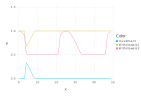

In [9]:
plot(x=repmat(time, 3), y=[getvalue(kk)[time]; getvalue(ww1)[time]; getvalue(ww2)[time]], color=repeat(["Investment", "Withdrawals 1", "Withdrawals 2"], inner=50), Geom.line)


# Progressive Optimization

In [10]:
kksaved = kk

kk[i] ≥ 0 ∀ i ∈ {0,1,…,48,49}

In [11]:
volume = Float64[0]
invested = Float64[0]
for tt0 in time
    println(tt0)
    subtime = time[time .>= tt0]
    subm = Model(solver=ClpSolver())

    @variable(subm, kk[subtime] >= 0) # Investment
    @variable(subm, xx1[subtime] >= 0) # Supersource under scenario 1
    @variable(subm, ww1[subtime] >= 0) # Withdrawals under scenario 1
    @variable(subm, xx2[subtime] >= 0) # Supersource under scenario 2
    @variable(subm, ww2[subtime] >= 0) # Withdrawals under scenario 2
        
    for tt1 in subtime
        # Always satisfy demand
        @constraint(subm, ww1[tt1] + xx1[tt1] >= demand[tt1 + 1])
        @constraint(subm, ww2[tt1] + xx2[tt1] >= demand[tt1 + 1])

        # Do not overfill reservoirs (v_t < V_t)
        @constraint(subm, volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))
        @constraint(subm, volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))

        # Do not withdraw more than available (w_t < v_t-1 + p_t)
        if (tt1 == tt0)
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + precip2[tt1+1])
        else
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:(tt1-1)) + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:(tt1-1)) + precip2[tt1+1])
        end
    end
    
    @objective(subm, Min, sum(((100xx1[tt] + 100xx2[tt])/2 + kk[tt]) * exp(-.05tt) for tt in subtime))
    
    status = solve(subm)
    push!(invested, getvalue(kk)[tt0])
    push!(volume, volume[end] + precip2[tt0+1] - getvalue(ww2)[tt0])
end

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


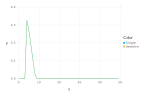

In [12]:
plot(x=repmat(time, 2), y=[getvalue(kksaved)[time]; invested[2:51]], color=repeat(["Single", "Iterative"], inner=50), Geom.line)


# Progressive Optimization with Scenario Updating

In [13]:
volume = Float64[0]
invested = Float64[0]
prob1 = .99
prob2 = .01
for tt0 in time
    println(tt0)
    subtime = time[time .>= tt0]
    subm = Model(solver=ClpSolver())

    @variable(subm, kk[subtime] >= 0) # Investment
    @variable(subm, xx1[subtime] >= 0) # Supersource under scenario 1
    @variable(subm, ww1[subtime] >= 0) # Withdrawals under scenario 1
    @variable(subm, xx2[subtime] >= 0) # Supersource under scenario 2
    @variable(subm, ww2[subtime] >= 0) # Withdrawals under scenario 2
        
    for tt1 in subtime
        # Always satisfy demand
        @constraint(subm, ww1[tt1] + xx1[tt1] >= demand[tt1 + 1])
        @constraint(subm, ww2[tt1] + xx2[tt1] >= demand[tt1 + 1])

        # Do not overfill reservoirs (v_t < V_t)
        @constraint(subm, volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))
        @constraint(subm, volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))

        # Do not withdraw more than available (w_t < v_t-1 + p_t)
        if (tt1 == tt0)
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + precip2[tt1+1])
        else
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:(tt1-1)) + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:(tt1-1)) + precip2[tt1+1])
        end
    end
    
    @objective(subm, Min, sum(((prob1 * 100xx1[tt] + prob2 * 100xx2[tt]) + kk[tt]) * exp(-.05tt) for tt in subtime))
    
    status = solve(subm)
    push!(invested, getvalue(kk)[tt0])
    push!(volume, volume[end] + precip2[tt0+1] - getvalue(ww2)[tt0])
end

volume = Float64[0]
invested = Float64[0]
prob1 = .99
prob2 = .01
for tt0 in time
    println(tt0)
    subtime = time[time .>= tt0]
    subm = Model(solver=ClpSolver())

    @variable(subm, kk[subtime] >= 0) # Investment
    @variable(subm, xx1[subtime] >= 0) # Supersource under scenario 1
    @variable(subm, ww1[subtime] >= 0) # Withdrawals under scenario 1
    @variable(subm, xx2[subtime] >= 0) # Supersource under scenario 2
    @variable(subm, ww2[subtime] >= 0) # Withdrawals under scenario 2
        
    for tt1 in subtime
        # Always satisfy demand
        @constraint(subm, ww1[tt1] + xx1[tt1] >= demand[tt1 + 1])
        @constraint(subm, ww2[tt1] + xx2[tt1] >= demand[tt1 + 1])

        # Do not overfill reservoirs (v_t < V_t)
        @constraint(subm, volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))
        @constraint(subm, volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))

        # Do not withdraw more than available (w_t < v_t-1 + p_t)
        if (tt1 == tt0)
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + precip2[tt1+1])
        else
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:(tt1-1)) + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:(tt1-1)) + precip2[tt1+1])
        end
    end
    
    @objective(subm, Min, sum(((prob1 * 100xx1[tt] + prob2 * 100xx2[tt]) + kk[tt]) * exp(-.05tt) for tt in subtime))
    
    status = solve(subm)
    push!(invested, getvalue(kk)[tt0])
    push!(volume, volume[end] + precip2[tt0+1] - getvalue(ww2)[tt0])
    prob1 = .999 * prob1
    prob2 = 1 - prob1
end

kksaved = invested

invested2 = invested

volume = Float64[0]
invested = Float64[0]
prob1 = .99
prob2 = .01
for tt0 in time
    println(tt0)
    subtime = time[time .>= tt0]
    subm = Model(solver=ClpSolver())

    @variable(subm, kk[subtime] >= 0) # Investment
    @variable(subm, xx1[subtime] >= 0) # Supersource under scenario 1
    @variable(subm, ww1[subtime] >= 0) # Withdrawals under scenario 1
    @variable(subm, xx2[subtime] >= 0) # Supersource under scenario 2
    @variable(subm, ww2[subtime] >= 0) # Withdrawals under scenario 2
        
    for tt1 in subtime
        # Always satisfy demand
        @constraint(subm, ww1[tt1] + xx1[tt1] >= demand[tt1 + 1])
        @constraint(subm, ww2[tt1] + xx2[tt1] >= demand[tt1 + 1])

        # Do not overfill reservoirs (v_t < V_t)
        @constraint(subm, volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))
        @constraint(subm, volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:tt1) <= sum(invested) + sum(kk[tt] for tt in tt0:tt1))

        # Do not withdraw more than available (w_t < v_t-1 + p_t)
        if (tt1 == tt0)
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + precip2[tt1+1])
        else
            @constraint(subm, ww1[tt1] <= volume[tt0 + 1] + sum(precip1[tt+1] - ww1[tt] for tt in tt0:(tt1-1)) + precip1[tt1+1])
            @constraint(subm, ww2[tt1] <= volume[tt0 + 1] + sum(precip2[tt+1] - ww2[tt] for tt in tt0:(tt1-1)) + precip2[tt1+1])
        end
    end
    
    @objective(subm, Min, sum(((prob1 * 100xx1[tt] + prob2 * 100xx2[tt]) + kk[tt]) * exp(-.05tt) for tt in subtime))
    
    status = solve(subm)
    push!(invested, getvalue(kk)[tt0])
    push!(volume, volume[end] + precip1[tt0+1] - getvalue(ww1)[tt0])
    prob2 = .999 * prob2
    prob1 = 1 - prob1
end

invested1 = invested

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


51-element Array{Float64,1}:
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0198672
 0.084339 
 0.0      
 0.0      
 0.0      
 0.0      
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      

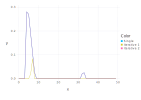

In [16]:
plot(x=repmat(time, 3), y=[kksaved[2:51]; invested1[2:51]; invested2[2:51]], color=repeat(["Single", "Iterative 1", "Iterative 2"], inner=50), Geom.line)
